In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   MultivariateNormalTransition, AdaptivePNormDistance,
                  PNormDistance, History)
from pyabc.visualization import plot_kde_matrix
from pyabc.sampler import DaskDistributedSampler
import pyabc.visualization
import logging
import scipy as sp
import scipy.stats as st
import tempfile
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dask.distributed import Client, LocalCluster
import csv


from tools.DataSimulator import simulate

### Setting up the pyabc run

In [2]:
# Initialize the dask cluster 
c = LocalCluster(n_workers=40, threads_per_worker = 1)
client = Client(c,timeout=90)

In [3]:
# Read the study data into a dictionary
study_data_path = os.path.abspath('data/data_adults.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data = {}
for row in reader:
   k, v = row
   study_data[k] = float(v)
study_data

{'0_4_Adults_mean': 17152.0,
 '10_4_Adults_mean': 14350.0,
 '20_4_Adults_mean': 11823.0,
 '40_4_Adults_mean': 12679.0,
 '80_4_Adults_mean': 12095.0,
 '160_4_Adults_mean': 11954.0,
 '0_5_Adults_mean': 19216.0,
 '10_5_Adults_mean': 17330.0,
 '20_5_Adults_mean': 15110.0,
 '40_5_Adults_mean': 10917.0,
 '80_5_Adults_mean': 7923.0,
 '160_5_Adults_mean': 5980.0,
 '0_6_Adults_mean': 18229.0,
 '10_6_Adults_mean': 17481.0,
 '20_6_Adults_mean': 17078.0,
 '40_6_Adults_mean': 15322.0,
 '80_6_Adults_mean': 6599.0,
 '160_6_Adults_mean': 2245.0,
 '0_7_Adults_mean': 12589.0,
 '10_7_Adults_mean': 14229.0,
 '20_7_Adults_mean': 18951.0,
 '40_7_Adults_mean': 17520.0,
 '80_7_Adults_mean': 16514.0,
 '160_7_Adults_mean': 478.0,
 '0_4_Adults_sd': 3874.0,
 '10_4_Adults_sd': 5023.0,
 '20_4_Adults_sd': 4745.0,
 '40_4_Adults_sd': 5132.0,
 '80_4_Adults_sd': 4682.0,
 '160_4_Adults_sd': 3807.0,
 '0_5_Adults_sd': 4729.0,
 '10_5_Adults_sd': 3807.0,
 '20_5_Adults_sd': 5023.0,
 '40_5_Adults_sd': 4847.0,
 '80_5_Adults_sd'

In [15]:
# Limits for the plots (accounts for the inverse log transform)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(0.0001, .5),
              AIAdultSlope=(1, 9),
              AILarvaLD50=(0.0001,.5),
              AILarvaSlope=(1, 9))


priors = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              #AIAdultLD50=(math.log10(.0001), math.log10(.5)), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AIAdultLD50=(-4, -.3),
              AIAdultSlope=(1, 9),
              #AILarvaLD50=(math.log10(.0001), math.log10(.5)), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AILarvaLD50=(-4,-.3),
              AILarvaSlope=(1, 9))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in priors.items()})

In [5]:
# Set our distance function and sampler
#distance = pyabc.AdaptivePNormDistance(p=2, adaptive=True)
distance = PNormDistance(p=2)

sampler = DaskDistributedSampler(dask_client = client)


In [6]:
# define the ABCSMC object
abc = ABCSMC(simulate, prior, distance,
             population_size=AdaptivePopulationSize(100, max_population_size = 300),
             sampler=sampler)

In [7]:
# Initialize a new ABC inference run
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "test_11_2.db"))
abc.new(db_path, study_data)


INFO:History:Start <ABCSMC(id=5, start_time=2018-11-02 15:19:19.459668, end_time=None)>
INFO:Epsilon:initial epsilon is 85945.30608905328


5

In [8]:
history = abc.run(max_nr_populations=1, minimum_epsilon=0)

INFO:ABC:t:0 eps:85945.30608905328
INFO:History:Done <ABCSMC(id=5, start_time=2018-11-02 15:19:19.459668, end_time=2018-11-02 15:25:28.113278)>


In [9]:
history.get_distribution(m=0)

(name  AIAdultLD50  AIAdultSlope  AILarvaLD50  AILarvaSlope  \
 id                                                           
 18       0.008069      4.196992     0.000207      3.578208   
 19       0.011230      3.690532     0.030522      2.356842   
 20       0.007894      1.783746     0.002514      4.268016   
 
 name  ICForagerLifespan_mean  ICForagerLifespan_sd  ICQueenStrength_mean  \
 id                                                                         
 18                  7.805634              0.133443              4.761225   
 19                  7.798275              2.399305              3.393335   
 20                 14.911247              2.807741              1.640235   
 
 name  ICQueenStrength_sd  
 id                        
 18              0.979945  
 19              0.492608  
 20              1.146565  , array([0.33333333, 0.33333333, 0.33333333]))

### Visualize results

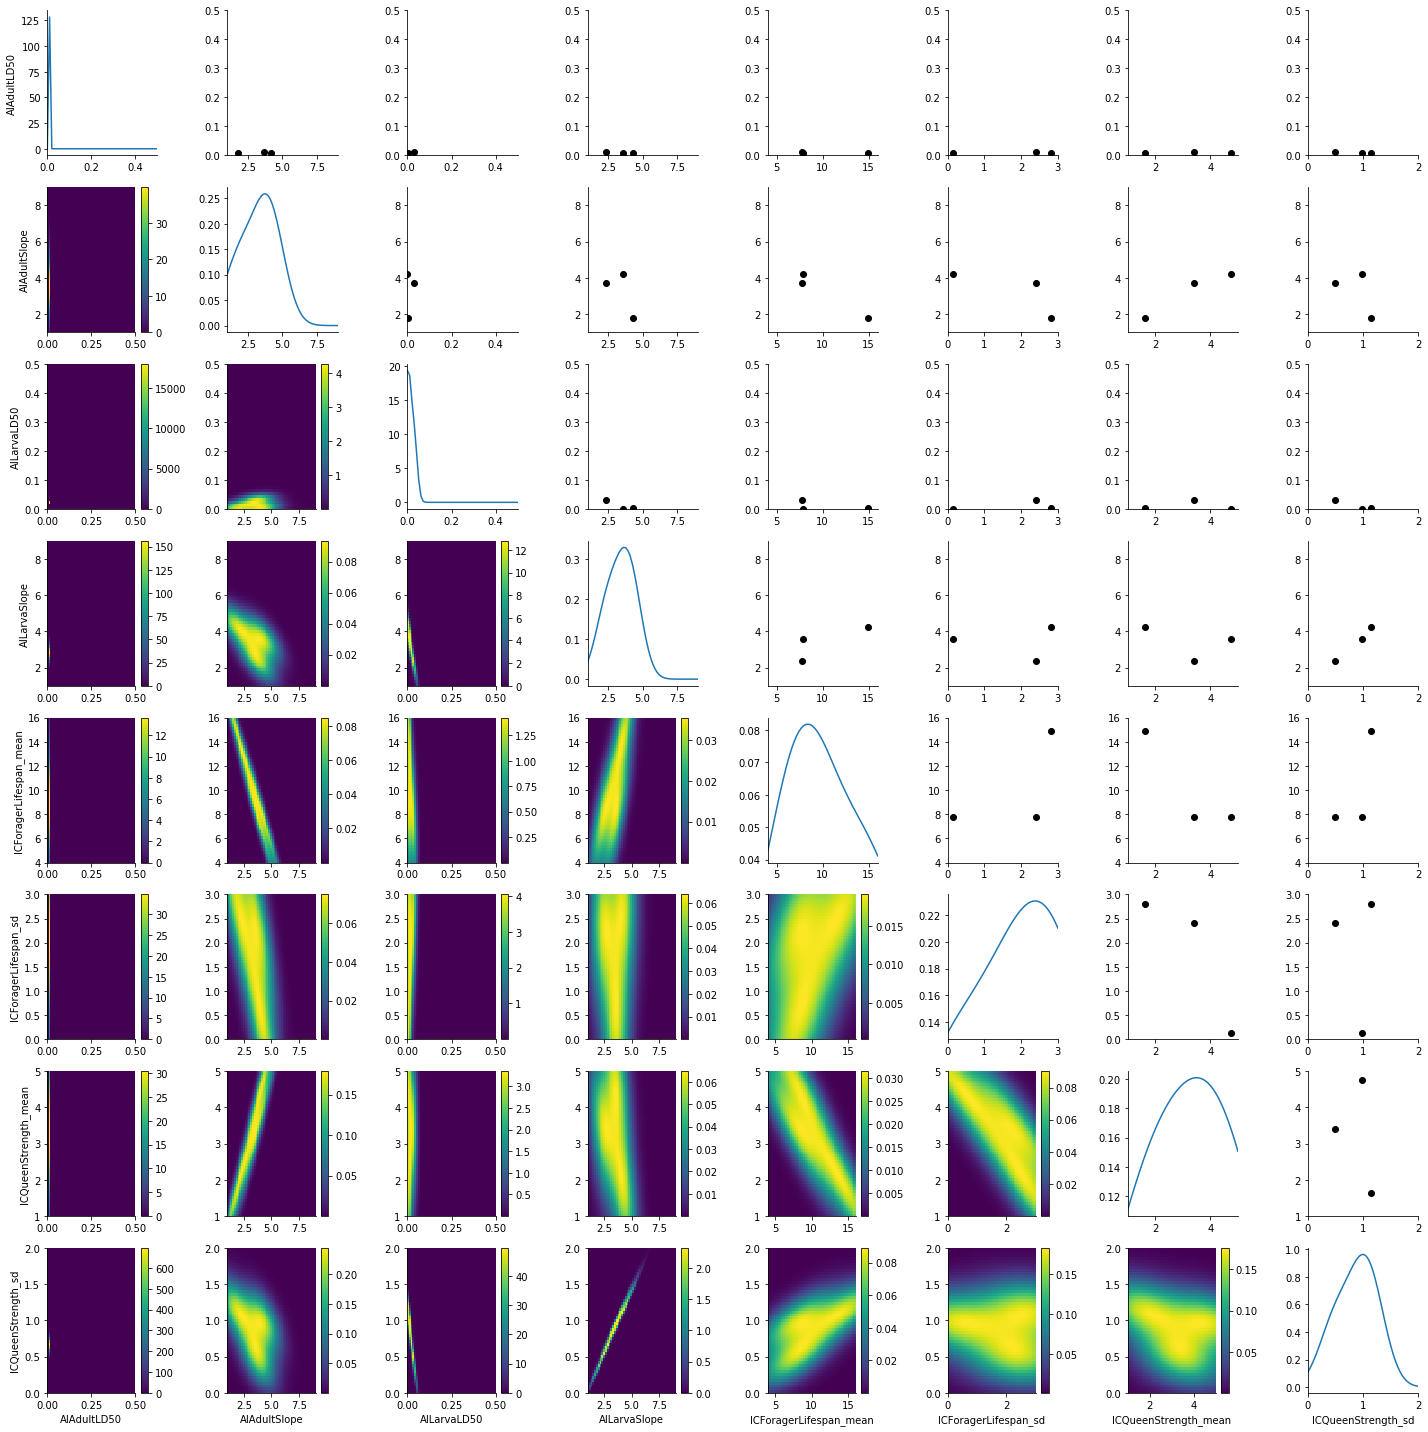

In [16]:
df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

### Visualize from a stored run

In [11]:
#retrieve stored run - run ID 7
#db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
#history = History(db_path)
#history.id = 7
#df, w = history.get_distribution(m=0, t=0)
#plot_kde_matrix(df, w, limits=limits);

In [12]:
df

name,AIAdultLD50,AIAdultSlope,AILarvaLD50,AILarvaSlope,ICForagerLifespan_mean,ICForagerLifespan_sd,ICQueenStrength_mean,ICQueenStrength_sd
id,,,,,,,,
18,0.008069,4.196992,0.000207,3.578208,7.805634,0.133443,4.761225,0.979945
19,0.011230,3.690532,0.030522,2.356842,7.798275,2.399305,3.393335,0.492608
20,0.007894,1.783746,0.002514,4.268016,14.911247,2.807741,1.640235,1.146565


In [13]:
history.get_all_populations()

,t,population_end_time,samples,epsilon,particles
0,-1,2018-11-02 15:19:21.741480,0,0.000000,1
1,0,2018-11-02 15:25:27.502982,2,85945.306089,3
